# Bayesian Seizure Likelihood Estimation

In [135]:
import pyro
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import torch
import zarr

from msc.data_utils import get_dataset, get_sample_rate_from_ds, get_config_dataset, get_sample_times, get_event_sample_times
from msc.plot_utils import plot_sample, set_size
from msc.prior_utils import get_events_df, vm_density, vm_mixture
from msc.time_utils import uSEC, SEC
from msc import config

plt.style.use(['science', 'no-latex'])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample space

* eeg plot example
* seizure sequence plot example

In [4]:

ds = get_config_dataset()

In [5]:
cache_zarr = zarr.open(f"{config['path']['data_v1']}/cache.zarr")
ds_zarr = cache_zarr[config['dataset_id']]

In [134]:
if False:
    # use this to see event history
    print(ds.get_annotations('seizures'))

In [6]:
mean = ds_zarr['mu']
std = ds_zarr['std']

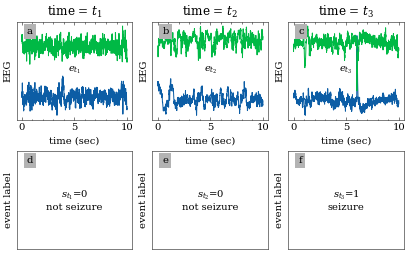

In [132]:
fig, axs = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'e', 'f']], constrained_layout=True, figsize=set_size(409))

sfreq = get_sample_rate_from_ds(ds)
sample_times = [300000, 3000000, 1247349926757/1e6]

for label, ax in axs.items():
    if label == 'a':
        sample = ds.get_data(sample_times[0], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_1}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_1$')

    elif label == 'b':
        sample = ds.get_data(sample_times[1], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_2}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_2$')
        
    elif label == 'c':
        sample = ds.get_data(sample_times[2], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_3}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_3$')


    elif label == 'd':
        ax.annotate("$s_{t_1}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])
        

    elif label == 'e':
        ax.annotate("$s_{t_2}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    elif label == 'f':
        ax.annotate("$s_{t_3}$=1\nseizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        ax.annotate("hello", xy=(0, 0))

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.savefig(f"{config['path']['figures']}/bsle_intro/sample_space.pdf", bbox_inches='tight')

## circular Gaussian mixture distribution

Forward-simulation of circular Gaussian distribution

Text(0.5, 0, 'time')

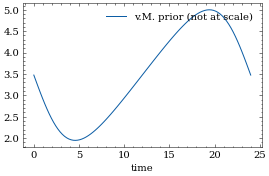

In [139]:
fig = plt.figure(figsize=set_size(309))

weights = np.arange(24)
X = np.linspace(0, 24, 100)
y = vm_mixture(X, weights)
y = 5 * y / max(y)  # TODO: make this same height as bar chart
plt.plot(X, y, label="v.M. prior (not at scale)")
legend = plt.legend(loc="upper right", framealpha=1)
# TODO: fix facecolor to white
frame = legend.get_frame()
frame.set_facecolor("white")
plt.xlabel("time")
# plt.title("")

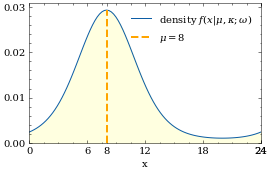

In [147]:
def plot_vmdensity(width, N=24, mu=8, k=1 / 0.6):
    X = np.linspace(0, N, 100)
    y = vm_density(X, mu=mu, k=k)

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="density $f(x | \mu, \kappa ; \omega)$")
    plt.fill_between(X, y, color="lightyellow")
    plt.vlines(
        [mu], 0, max(y), linestyles="dashed", colors="orange", lw=2, label=f"$\mu={mu}$"
    )
    plt.xlabel("x")
    extraticks = [mu, N]
    plt.xticks([0, 6, 12, 18, 24] + extraticks)
    plt.xlim(0, N)
    plt.ylim(bottom=0)
    plt.legend()

plot_vmdensity(150)

# plt.savefig(f"{config['path']['figures']}/bsle_intro/vm_density.pdf", bbox_inches="tight")

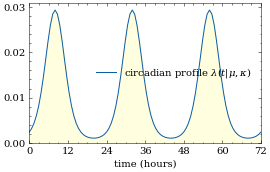

In [161]:
def plot_long_vmdensity(width, N=24, mu=8, k=1 / 0.6, repeat=3):
    X = np.linspace(0, repeat * N, 100)
    y = vm_density(X, mu=mu, k=k)

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="circadian profile $\lambda(t | \mu, \kappa)$")
    plt.fill_between(X, y, color="lightyellow")

    plt.xlabel("time (hours)")
    plt.xticks([0, 12, 24, 36, 48, 60, 72])
    plt.xlim(0, repeat * N)
    plt.ylim(bottom=0)
    legend = plt.legend(facecolor='white', framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("white")

plot_long_vmdensity(300)

plt.savefig(f"{config['path']['figures']}/bsle_intro/long_vm_density.pdf", bbox_inches="tight")

## Build the inference engine

In [12]:
def model():
    

SyntaxError: unexpected EOF while parsing (3468611879.py, line 2)

## Run the inference engine

## Plot the inference engine results

## Empirical events - subject_id

## Plot the inference of the empirical data

## Sampling the Cox Process

## Inferring the Latent Intensity Function

## Checking the Model